In [64]:
import numpy as np
import matplotlib.pyplot as plt
from DEBT_control_class import DEBT_Control_Protocol
import logging, sys
logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


In [65]:
def cyclic_example_generate_params():
    n = 3
    params = dict()
    params["custom"] = True
    params["capacity_matrix"] = np.array([[0, 100, 100], [100, 0, 100], [100, 100, 0]])

    params["custom_routes"] = True
    paths = dict()
    empty_path = np.zeros((3, 3))
    paths[(0,1)] = [empty_path.copy(), empty_path.copy()]
    paths[(0,1)][0][0,1] = 1
    paths[(0,1)][1][0,2] = 1
    paths[(0,1)][1][2,1] = 1
    paths[(1,2)] = [empty_path.copy(), empty_path.copy()]
    paths[(1,2)][0][1,2] = 1
    paths[(1,2)][1][1,0] = 1
    paths[(1,2)][1][0,2] = 1
    paths[(2,0)] = [empty_path.copy(), empty_path.copy()]
    paths[(2,0)][0][2,0] = 1
    paths[(2,0)][1][2,1] = 1
    paths[(2,0)][1][1,0] = 1
    params["routes"] = paths

    demand_params = dict()
    demand_params["custom demands"] = True
    demand_params["demand_matrix"] = np.array([[0, 10, 0], [0, 0, 10], [10, 0, 0]])
    demand_params["distribution"] = "deterministic"
    return params, demand_params, n

In [66]:
def deadlock_example_generate_params():
    n = 3
    params = dict()
    params["custom"] = True
    params["capacity_matrix"] = np.array([[0, 100, 0], [100, 0, 100], [0, 100, 0]])

    params["custom_routes"] = True
    paths = dict()
    empty_path = np.zeros((3, 3))
    paths[(0,2)] = [empty_path.copy()]
    paths[(0,2)][0][0,1] = 1
    paths[(0,2)][0][1,2] = 1
    paths[(2,0)] = [empty_path.copy()]
    paths[(2,0)][0][2,1] = 1
    paths[(2,0)][0][1,0] = 1
    paths[(1,2)] = [empty_path.copy()]
    paths[(1,2)][0][1,2] = 1
    paths[(1,0)] = [empty_path.copy()]
    paths[(1,0)][0][1,0] = 1
    params["routes"] = paths

    demand_params = dict()
    demand_params["custom demands"] = True
    demand_params["demand_matrix"] = np.array([[0, 0, 10], [10, 0, 10], [10, 0, 0]])
    demand_params["distribution"] = "deterministic"
    return params, demand_params, n

In [67]:
params, demand_params, n = deadlock_example_generate_params()
price_params = dict()
price_params["stepsize"] = 0.005
price_params["threshold"] = 2*np.ones((n,n))
price_params["sensitivity"] = 0.1*np.ones((n,n))

In [68]:
# initialize the PCN and the protocol
myPCN = DEBT_Control_Protocol(params, demand_params, price_params) 
# loop for T time steps
T = 100

INFO:root:initializing PCN
DEBUG:root:Initially, the balances are as follows:
DEBUG:root:[[ 0. 50.  0.]
 [50.  0. 50.]
 [ 0. 50.  0.]]
INFO:root:finished initializing PCN
INFO:root:initializing demands
INFO:root:custom demand matrix
INFO:root:finished initializing demands
INFO:root:initializing prices
INFO:root:finished initializing prices


In [69]:
# create arrays to store flows and prices
flows_data = dict()
path_price_data = dict()
for i in range(n):
    for j in range(n):
        if (i,j) not in myPCN.paths.keys():
            continue
        flows_data[(i,j)] = np.zeros((T,len(myPCN.paths[(i,j)])))
        path_price_data[(i,j)] = np.zeros((T,len(myPCN.paths[(i,j)])))
edge_price_data = np.zeros((T, n, n))
reset_data = np.zeros((T, n, n))

In [70]:
logging.info("starting loop with %d iterations", T)
for t in range(T):
    logging.info("starting step %d", t)
    myPCN.single_step(t)
    edge_price_data[t] = myPCN.channel_prices.copy()
    for key in flows_data.keys():
        flows_data[key][t] = myPCN.flow_requests[key]
        path_price_data[key][t] = myPCN.path_prices[key]
        reset_data[t] = myPCN.channels_reset


INFO:root:starting loop with 100 iterations
INFO:root:starting step 0
INFO:root:generating transaction requests
INFO:root:finished generating transaction requests
INFO:root:computing path prices
INFO:root:finished computing path prices
INFO:root:deciding flows
INFO:root:calculating flows for (0, 2) node pair
INFO:root:performing soft routing
DEBUG:root:The path prices are [0.0] and the maximum price is 2.000000
DEBUG:root:In iteration 0 of soft routing with 10.000000 flow remaining
DEBUG:root:filled upto maximum demand, breaking the loop
DEBUG:root:flow vector for node pair (0, 2) is: [10.]
INFO:root:calculating flows for (2, 0) node pair
INFO:root:performing soft routing
DEBUG:root:The path prices are [0.0] and the maximum price is 2.000000
DEBUG:root:In iteration 0 of soft routing with 10.000000 flow remaining
DEBUG:root:filled upto maximum demand, breaking the loop
DEBUG:root:flow vector for node pair (2, 0) is: [10.]
INFO:root:calculating flows for (1, 2) node pair
INFO:root:perfor

Text(0.5, 1.0, 'Flows as a function of time')

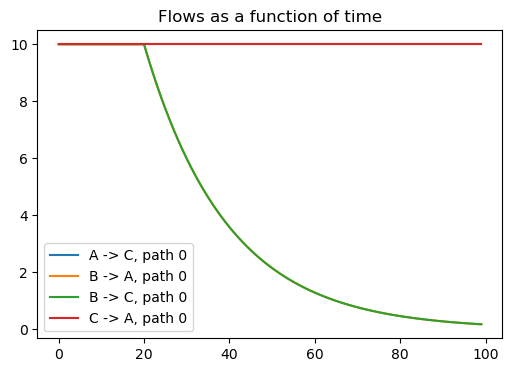

In [71]:
alphabets = ['A', 'B', 'C', 'D', 'E', 'F']
plt.close("all")
plt.figure(figsize=(6,4))
for i in range(n):
    for j in range(n):
        if myPCN.demands[i,j] > 0:
            for k in range(len(myPCN.paths[(i,j)])):
                plt.plot(flows_data[(i,j)][:,k], label = alphabets[i] + " -> " + alphabets[j] + ", path " + str(k))
plt.legend()
plt.title("Flows as a function of time")

Text(0.5, 1.0, 'Prices as a function of time')

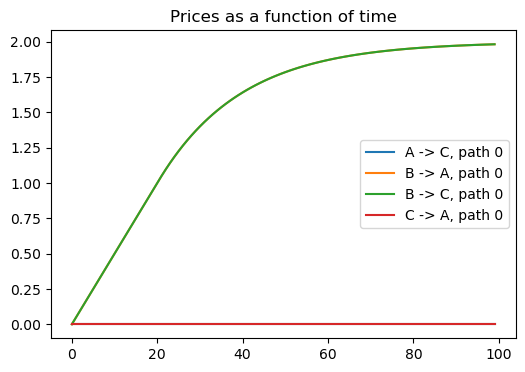

In [72]:
plt.figure(figsize=(6,4))
for i in range(n):
    for j in range(n):
        if myPCN.demands[i,j] > 0:
            for k in range(len(myPCN.paths[(i,j)])):
                plt.plot(path_price_data[(i,j)][:,k], label = alphabets[i] + " -> " + alphabets[j] + ", path " + str(k))
plt.legend()
plt.title("Prices as a function of time")